In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from utilsforecast.plotting import plot_series
from utilsforecast.evaluation import evaluate

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [4]:
print("torch:", torch.__version__)
device = "cuda" if torch.cuda.is_available() else "cpu"
device

torch: 2.10.0+cu128


'cuda'

In [3]:
df = pd.read_csv("./data/nepsealpha_export_price_NTC_2021-01-03_2026-01-03_unadjusted.csv", encoding="latin1")
df.head()

,Symbol,Date,Open,High,Low,Close,Percent Change,Volume,Turn Over
0,NTC,2026-01-01,905.0,909.0,902.2,905.0,0.00 %,"74,592.00","67,568,456.30"
1,NTC,2025-12-31,909.0,909.0,900.0,905.0,0.02 %,"40,304.00","36,498,409.60"
2,NTC,2025-12-29,908.0,911.0,898.0,904.8,-0.13 %,"38,244.00","34,636,425.70"
3,NTC,2025-12-28,909.9,909.9,896.0,906.0,1.18 %,"38,661.00","34,912,329.80"
4,NTC,2025-12-24,916.9,916.9,890.0,895.4,-0.40 %,"39,968.00","35,856,692.70"


In [4]:
df['Date'] = pd.to_datetime(df['Date'])

In [5]:
# df.drop("Percent Change",axis=1,inplace=True)
# df.drop("Volume",axis=1,inplace=True)
df.drop("Symbol",axis=1,inplace=True)
df.drop("Turn Over",axis=1,inplace=True)

In [6]:
df['Percent Change'] = df['Percent Change'].str.replace('%', '').astype(float) / 100
df['price_change'] = df['Percent Change'] * df['Close']

In [7]:
df['price_change'] = df['price_change'].round(1)
df.drop("Percent Change",axis=1,inplace=True)

In [8]:
df.head()

,Date,Open,High,Low,Close,Volume,price_change
0,2026-01-01,905.0,909.0,902.2,905.0,"74,592.00",0.0
1,2025-12-31,909.0,909.0,900.0,905.0,"40,304.00",0.2
2,2025-12-29,908.0,911.0,898.0,904.8,"38,244.00",-1.2
3,2025-12-28,909.9,909.9,896.0,906.0,"38,661.00",10.7
4,2025-12-24,916.9,916.9,890.0,895.4,"39,968.00",-3.6


In [9]:
df['Volume'] = df['Volume'].astype(str).str.replace(',', '', regex=False)
df['Volume'] = df['Volume'].replace('-', 0) # Replace hyphens with NaN
df['Volume'] = pd.to_numeric(df['Volume'])

In [10]:
df

,Date,Open,High,Low,Close,Volume,price_change
0,2026-01-01,905.0,909.0,902.2,905.0,74592.0,0.0
1,2025-12-31,909.0,909.0,900.0,905.0,40304.0,0.2
2,2025-12-29,908.0,911.0,898.0,904.8,38244.0,-1.2
3,2025-12-28,909.9,909.9,896.0,906.0,38661.0,10.7
4,2025-12-24,916.9,916.9,890.0,895.4,39968.0,-3.6
...,...,...,...,...,...,...,...
1161,2021-01-07,1282.0,1295.0,1263.0,1268.0,0.0,-0.3
1162,2021-01-06,1300.0,1300.0,1277.0,1288.0,0.0,0.1
1163,2021-01-05,1250.0,1306.0,1250.0,1275.0,0.0,-0.1
1164,2021-01-04,1320.0,1346.0,1270.0,1291.0,0.0,-0.1


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1166 entries, 0 to 1165
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          1166 non-null   datetime64[ns]
 1   Open          1166 non-null   float64       
 2   High          1166 non-null   float64       
 3   Low           1166 non-null   float64       
 4   Close         1166 non-null   float64       
 5   Volume        1166 non-null   float64       
 6   price_change  1166 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 63.9 KB


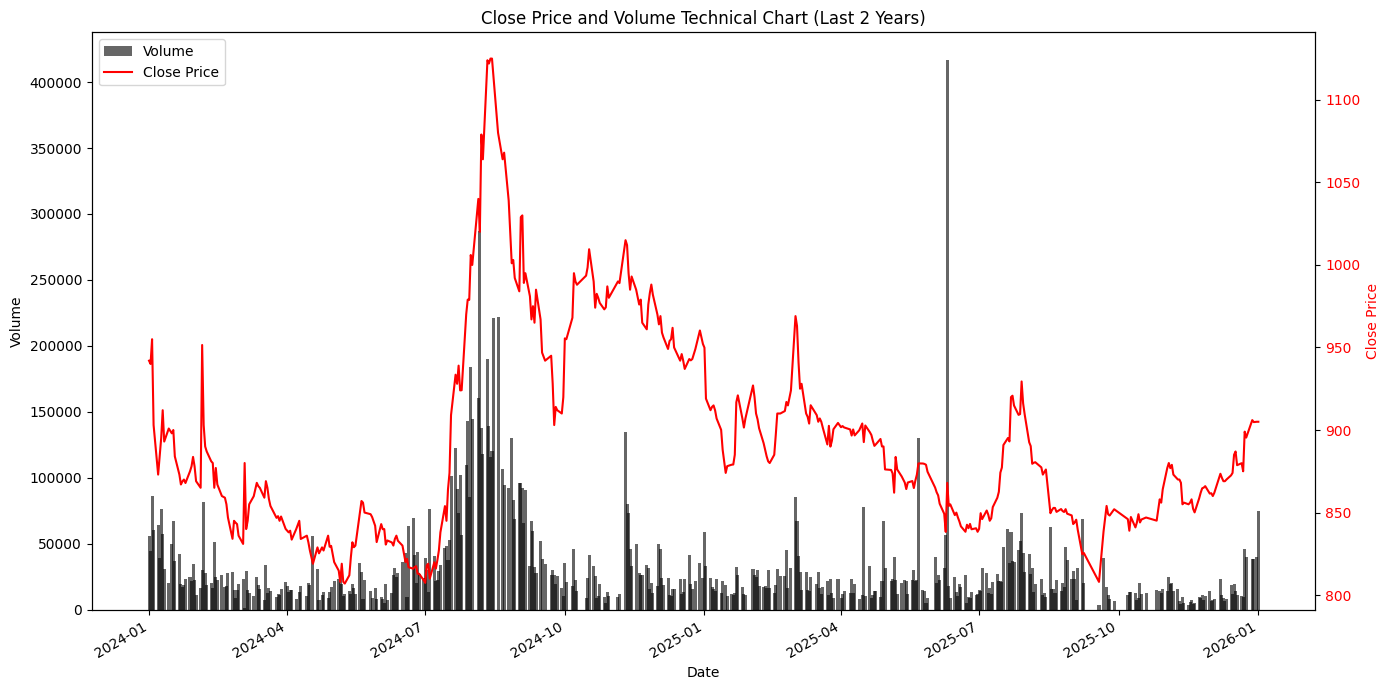

In [12]:
import matplotlib.pyplot as plt

# Ensure the DataFrame is sorted by Date
df_sorted = df.sort_values(by='Date').copy()

# Filter for the last 2 years of data
end_date = df_sorted['Date'].max()
start_date = end_date - pd.DateOffset(years=2)
df_filtered = df_sorted[(df_sorted['Date'] >= start_date) & (df_sorted['Date'] <= end_date)]

# Create figure and primary axes for Volume
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot Volume as a bar chart on ax1
ax1.bar(df_filtered['Date'], df_filtered['Volume'], color='black', alpha=0.6, label='Volume', width=2)
ax1.set_xlabel('Date')
ax1.set_ylabel('Volume', color='black')
ax1.tick_params(axis='y', labelcolor='black')

# Create a second y-axis for Close price
ax2 = ax1.twinx()

# Plot Close price as a line chart on ax2
ax2.plot(df_filtered['Date'], df_filtered['Close'], color='red', label='Close Price')
ax2.set_ylabel('Close Price', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Set chart title and legends
plt.title('Close Price and Volume Technical Chart (Last 2 Years)')

# Combine legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

# Rotate x-axis labels for better readability
fig.autofmt_xdate()

plt.tight_layout()
plt.show()

In [13]:
df_long = df.melt(
    id_vars=["Date"],
    value_vars=["Open", "High", "Low", "Close","Volume","price_change"],
    var_name="unique_id",
    value_name="y"
).rename(columns={"Date": "ds"})

In [14]:
df_long.head()

,ds,unique_id,y
0,2026-01-01,Open,905.0
1,2025-12-31,Open,909.0
2,2025-12-29,Open,908.0
3,2025-12-28,Open,909.9
4,2025-12-24,Open,916.9


In [15]:
df_long = (
    df_long
    .groupby(['ds', 'unique_id'], as_index=False)['y']
    .mean()
)


In [16]:
df_long

,ds,unique_id,y
0,2021-01-03,Close,1302.0
1,2021-01-03,High,1304.0
2,2021-01-03,Low,1225.0
3,2021-01-03,Open,1235.0
4,2021-01-03,Volume,0.0
...,...,...,...
6991,2026-01-01,High,909.0
6992,2026-01-01,Low,902.2
6993,2026-01-01,Open,905.0
6994,2026-01-01,Volume,74592.0


In [17]:
df_long.info

<bound method DataFrame.info of              ds     unique_id        y
0    2021-01-03         Close   1302.0
1    2021-01-03          High   1304.0
2    2021-01-03           Low   1225.0
3    2021-01-03          Open   1235.0
4    2021-01-03        Volume      0.0
...         ...           ...      ...
6991 2026-01-01          High    909.0
6992 2026-01-01           Low    902.2
6993 2026-01-01          Open    905.0
6994 2026-01-01        Volume  74592.0
6995 2026-01-01  price_change      0.0

[6996 rows x 3 columns]>

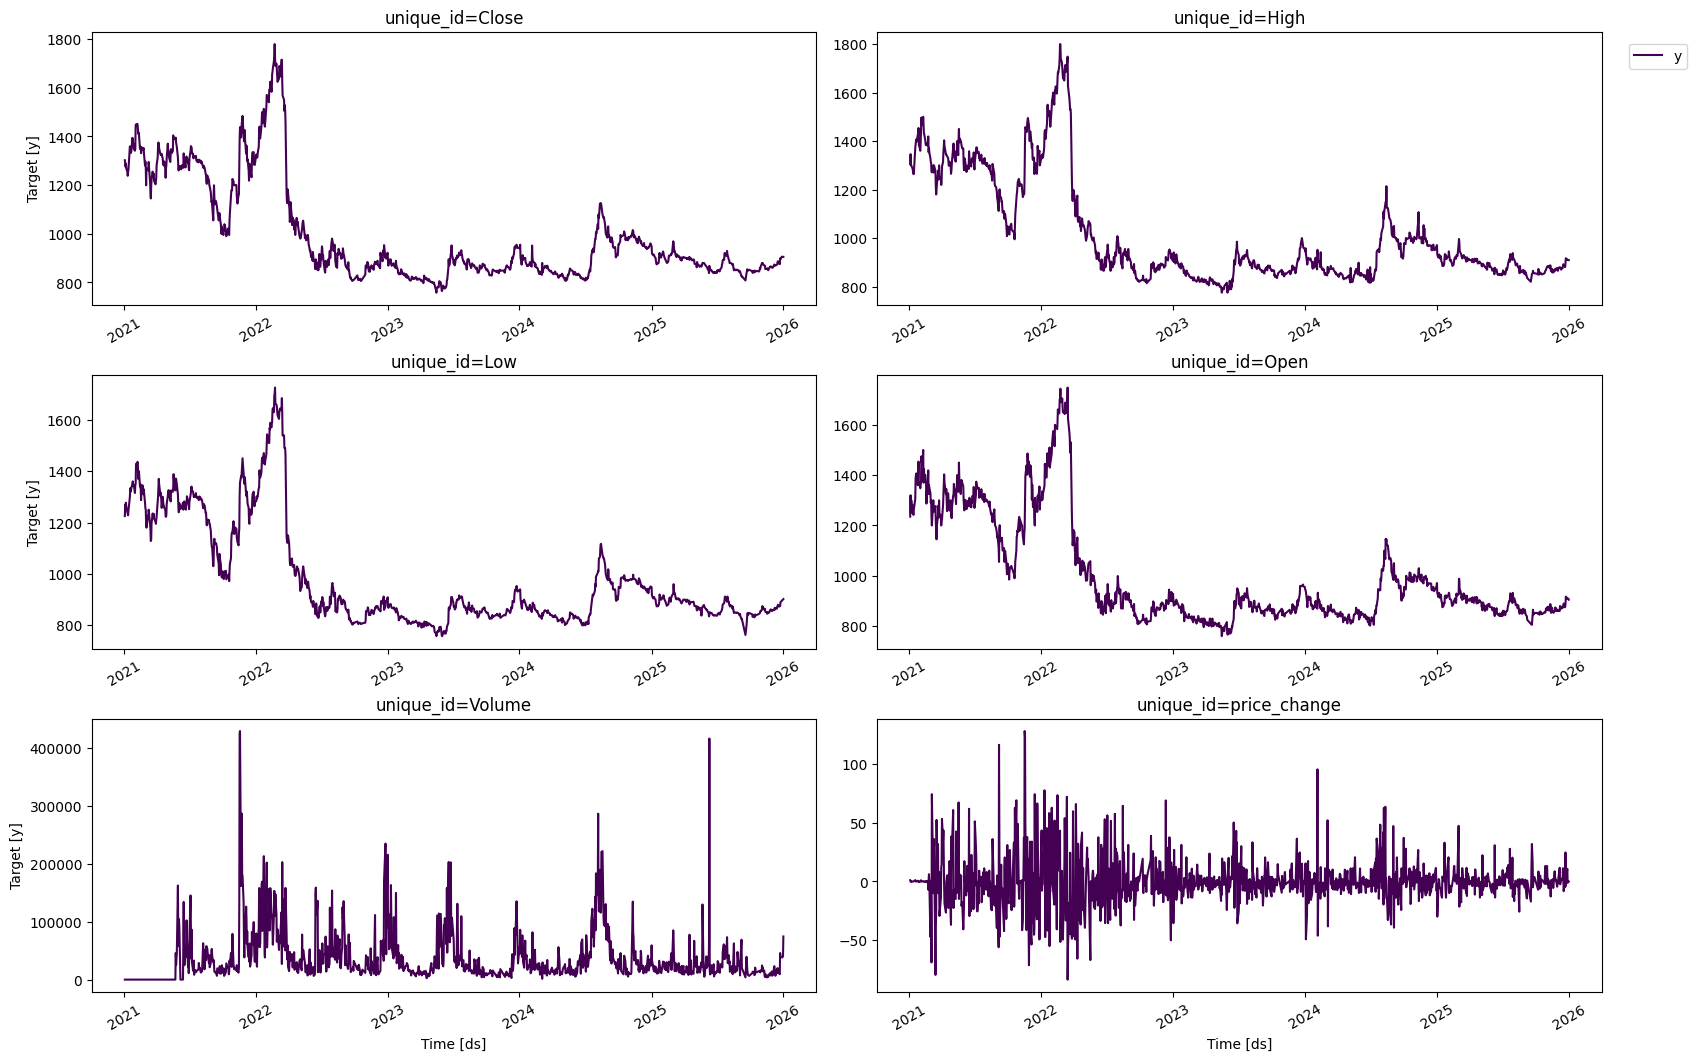

In [18]:
plot_series(df=df_long, palette="viridis")

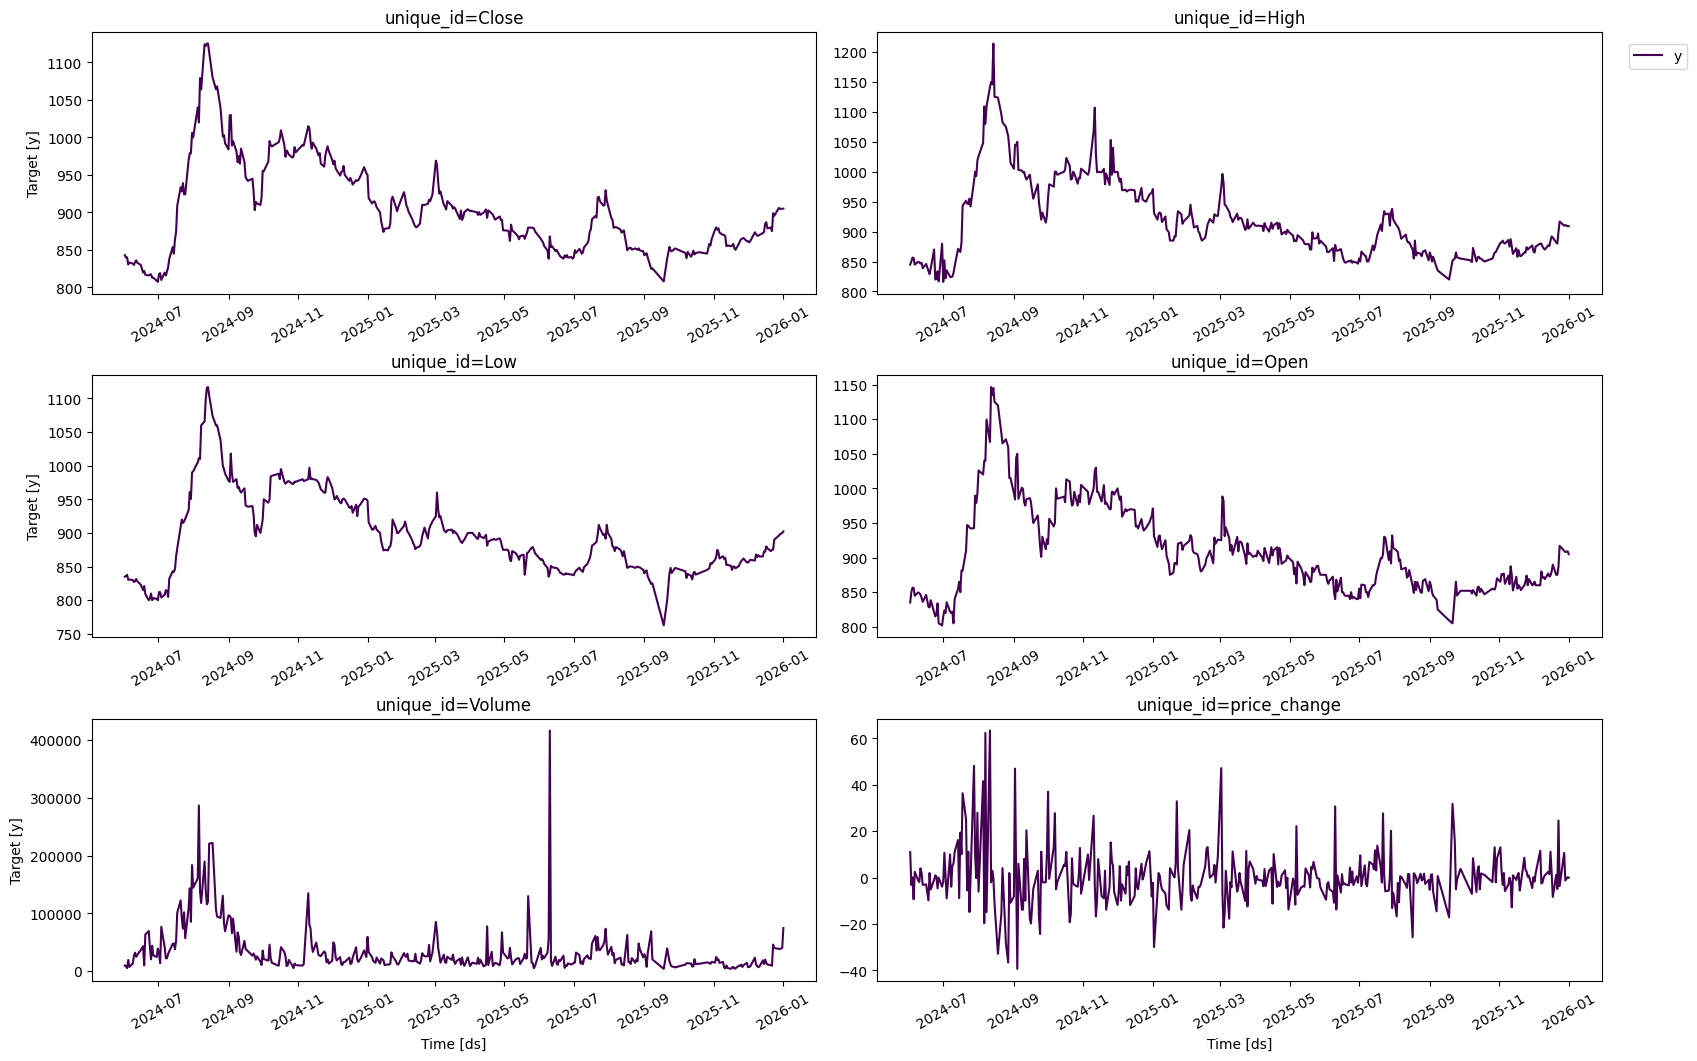

In [19]:
plot_series(df=df_long, max_insample_length=30*12, palette="viridis")

Time Series Decomposition

In [20]:
from statsmodels.tsa.seasonal import seasonal_decompose

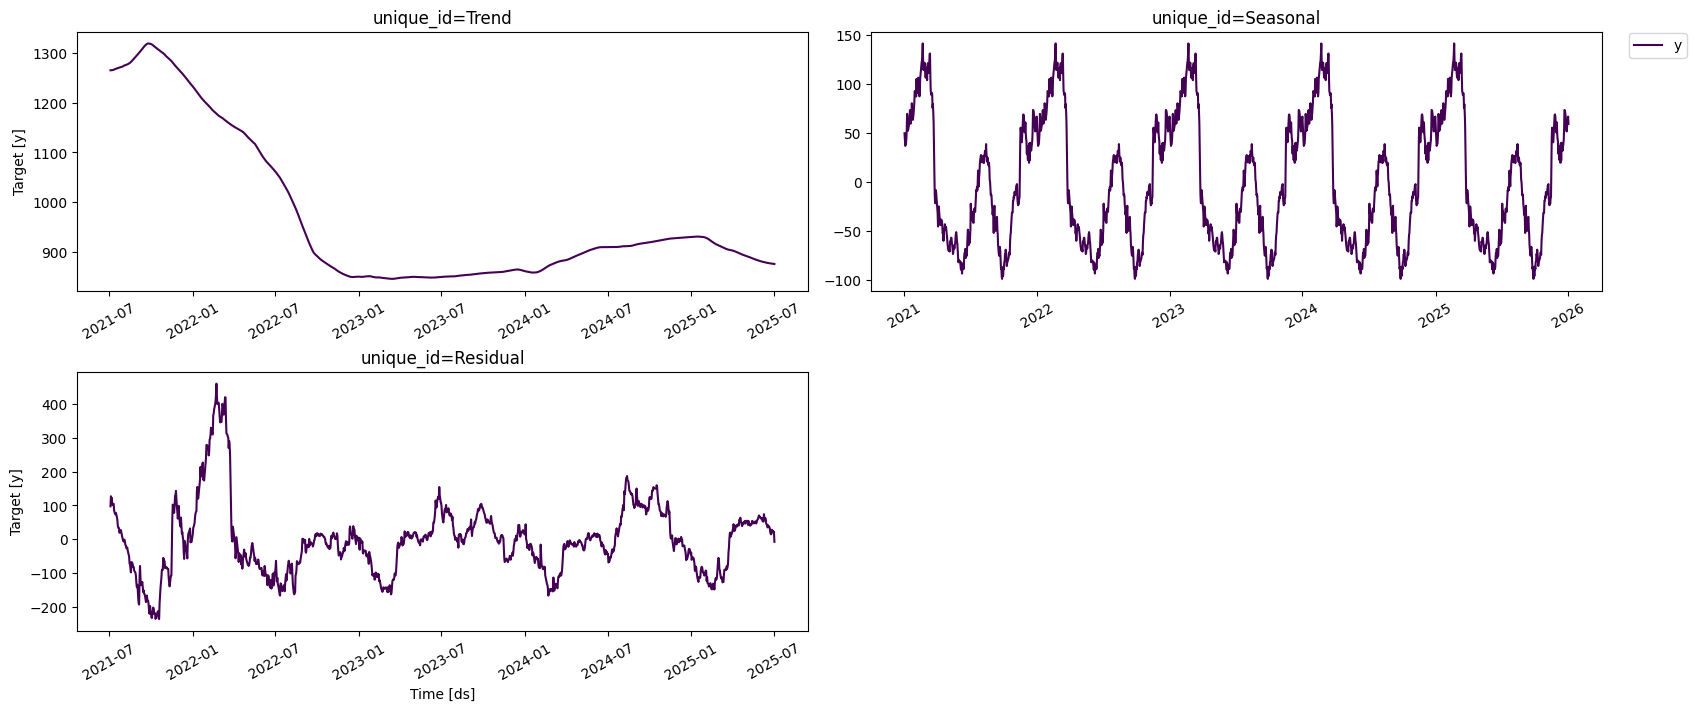

In [21]:
var = "Close"
ts = (
    df_long[df_long["unique_id"] == var]
    .set_index("ds")["y"]
    .asfreq("D") # Changed from "h" to "D" for daily data
    .interpolate(method="linear") # Interpolate missing values
)

result = seasonal_decompose(ts, model="additive", period=365) # Changed period to 7 for weekly seasonality

components_long = pd.concat([
    result.trend.rename("Trend"),
    result.seasonal.rename("Seasonal"),
    result.resid.rename("Residual")
], axis=1).reset_index().melt(id_vars="ds", var_name="unique_id", value_name="y")

plot_series(
    df=pd.DataFrame({"ds": ts.index, "unique_id": var, "y": ts.values}),
    max_insample_length=365, # Adjusted for daily data plotting length
    forecasts_df=components_long,
    ids=["Trend", "Seasonal", "Residual"],
    palette="viridis"
)

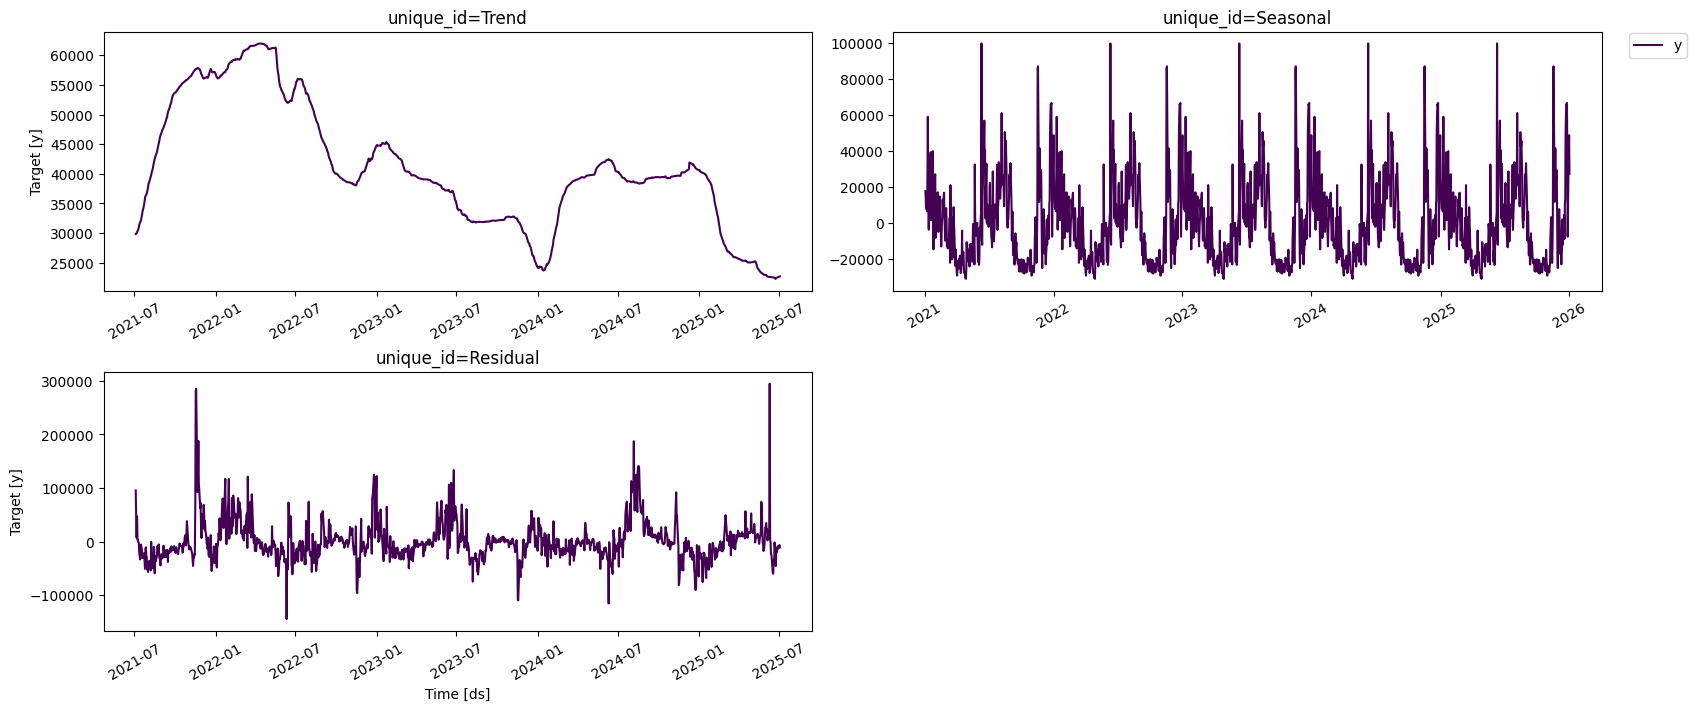

In [22]:
var = "Volume"
ts = (
    df_long[df_long["unique_id"] == var]
    .set_index("ds")["y"]
    .asfreq("D")
    .interpolate(method="linear")
)

result = seasonal_decompose(ts, model="additive", period=365)

components_long = pd.concat([
    result.trend.rename("Trend"),
    result.seasonal.rename("Seasonal"),
    result.resid.rename("Residual")
], axis=1).reset_index().melt(id_vars="ds", var_name="unique_id", value_name="y")

plot_series(
    df=pd.DataFrame({"ds": ts.index, "unique_id": var, "y": ts.values}),
    max_insample_length=365,
    forecasts_df=components_long,
    ids=["Trend", "Seasonal", "Residual"],
    palette="viridis"
)

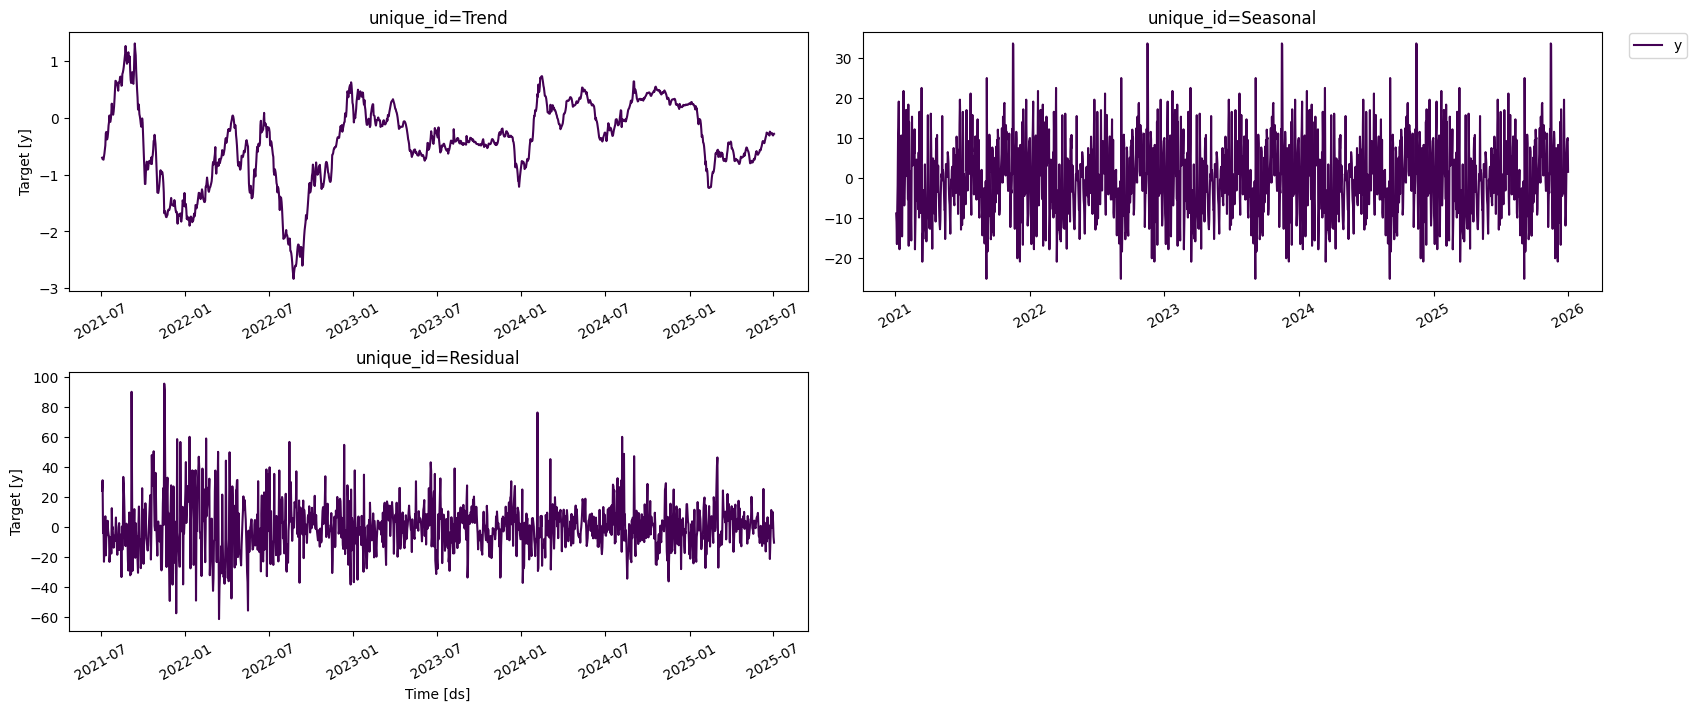

In [23]:
var = "price_change"
ts = (
    df_long[df_long["unique_id"] == var]
    .set_index("ds")["y"]
    .asfreq("D") # Changed from "h" to "D" for daily data
    .interpolate(method="linear") # Interpolate missing values
)

result = seasonal_decompose(ts, model="additive", period=365) # Changed period to 7 for weekly seasonality

components_long = pd.concat([
    result.trend.rename("Trend"),
    result.seasonal.rename("Seasonal"),
    result.resid.rename("Residual")
], axis=1).reset_index().melt(id_vars="ds", var_name="unique_id", value_name="y")

plot_series(
    df=pd.DataFrame({"ds": ts.index, "unique_id": var, "y": ts.values}),
    max_insample_length=365, # Adjusted for daily data plotting length
    forecasts_df=components_long,
    ids=["Trend", "Seasonal", "Residual"],
    palette="viridis"
)

In [24]:
df.head()

,Date,Open,High,Low,Close,Volume,price_change
0,2026-01-01,905.0,909.0,902.2,905.0,74592.0,0.0
1,2025-12-31,909.0,909.0,900.0,905.0,40304.0,0.2
2,2025-12-29,908.0,911.0,898.0,904.8,38244.0,-1.2
3,2025-12-28,909.9,909.9,896.0,906.0,38661.0,10.7
4,2025-12-24,916.9,916.9,890.0,895.4,39968.0,-3.6


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1166 entries, 0 to 1165
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          1166 non-null   datetime64[ns]
 1   Open          1166 non-null   float64       
 2   High          1166 non-null   float64       
 3   Low           1166 non-null   float64       
 4   Close         1166 non-null   float64       
 5   Volume        1166 non-null   float64       
 6   price_change  1166 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 63.9 KB


In [26]:
df.index = pd.to_datetime(df['Date'], format = '%Y-%m-%d')

In [27]:
df.head()

,Date,Open,High,Low,Close,Volume,price_change
Date,,,,,,,
2026-01-01,2026-01-01,905.0,909.0,902.2,905.0,74592.0,0.0
2025-12-31,2025-12-31,909.0,909.0,900.0,905.0,40304.0,0.2
2025-12-29,2025-12-29,908.0,911.0,898.0,904.8,38244.0,-1.2
2025-12-28,2025-12-28,909.9,909.9,896.0,906.0,38661.0,10.7
2025-12-24,2025-12-24,916.9,916.9,890.0,895.4,39968.0,-3.6


In [28]:
df['Date'] = pd.to_datetime(df['Date'])

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1166 entries, 2026-01-01 to 2021-01-03
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          1166 non-null   datetime64[ns]
 1   Open          1166 non-null   float64       
 2   High          1166 non-null   float64       
 3   Low           1166 non-null   float64       
 4   Close         1166 non-null   float64       
 5   Volume        1166 non-null   float64       
 6   price_change  1166 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 72.9 KB


In [30]:
df.drop("Date",axis=1,inplace=True)


In [31]:
df.dropna(inplace=True)

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1166 entries, 2026-01-01 to 2021-01-03
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          1166 non-null   float64
 1   High          1166 non-null   float64
 2   Low           1166 non-null   float64
 3   Close         1166 non-null   float64
 4   Volume        1166 non-null   float64
 5   price_change  1166 non-null   float64
dtypes: float64(6)
memory usage: 63.8 KB


In [33]:
def calculate_technical_indicators(df):
    # Calculate RSI
    def RSI(series, period):
        delta = series.diff(1)
        gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
        RS = gain / loss
        return 100 - (100 / (1 + RS))
    df['momentum_rsi'] = RSI(df['Close'],14)
    
    # Calculate SMA
    df['trend_sma_fast'] = df['Close'].rolling(window=10).mean()
    
    # Calculate WMA
    weights = np.arange(1, 11)
    df['wma'] = df['Close'].rolling(10).apply(lambda prices: np.dot(prices, weights) / weights.sum(), raw=True)
    
    # Calculate Momentum
    df['momentum'] = df['Close'].diff(10)
    
    # Calculate MACD
    df['EMA12'] = df['Close'].ewm(span=12, adjust=False).mean()
    df['EMA26'] = df['Close'].ewm(span=26, adjust=False).mean()
    df['trend_macd'] = df['EMA12'] - df['EMA26']
    
    # Calculate Stochastic Oscillator K% and D%
    low_min = df['Low'].rolling(window=14).min()
    high_max = df['High'].rolling(window=14).max()
    df['stoch_k'] = 100 * ((df['Close'] - low_min) / (high_max - low_min))
    df['stoch_d'] = df['stoch_k'].rolling(window=3).mean()
    
    # Calculate William's %R
    df['momentum_wr'] = -100 * (high_max - df['Close']) / (high_max - low_min)
    
    # Calculate CCI
    TP = (df['Close'] + df['High'] + df['Low']) / 3
    df['trend_cci'] = (TP - TP.rolling(window=20).mean()) / (0.015 * TP.rolling(window=20).std())
    
    # Calculate A/D Oscillator
    df['volume_adi'] = ((df['Close'] - df['Low']) - (df['High'] - df['Close'])) / (df['High'] - df['Low'])
    
    # Calculate HMA
    def WMA(series, window):
        weights = np.arange(1, window + 1)
        return series.rolling(window).apply(lambda prices: np.dot(prices, weights) / weights.sum(), raw=True)
    
    def HMA(series, window):
        half_length = int(window / 2)
        sqrt_length = int(np.sqrt(window))
        WMA_half = WMA(series, half_length)
        WMA_full = WMA(series, window)
        HMA = WMA(2 * WMA_half - WMA_full, sqrt_length)
        return HMA
    
    df['hma'] = HMA(df['Close'], 10)
    
    return df

# Calculate technical indicators
dataframe = calculate_technical_indicators(df)

# Display the first few rows with technical indicators
dataframe

,Open,High,Low,Close,Volume,price_change,momentum_rsi,trend_sma_fast,wma,momentum,EMA12,EMA26,trend_macd,stoch_k,stoch_d,momentum_wr,trend_cci,volume_adi,hma
Date,,,,,,,,,,,,,,,,,,,
2026-01-01,905.0,909.0,902.2,905.0,74592.0,0.0,NaN,NaN,NaN,NaN,905.000000,905.000000,0.000000,NaN,NaN,NaN,NaN,-0.176471,NaN
2025-12-31,909.0,909.0,900.0,905.0,40304.0,0.2,NaN,NaN,NaN,NaN,905.000000,905.000000,0.000000,NaN,NaN,NaN,NaN,0.111111,NaN
2025-12-29,908.0,911.0,898.0,904.8,38244.0,-1.2,NaN,NaN,NaN,NaN,904.969231,904.985185,-0.015954,NaN,NaN,NaN,NaN,0.046154,NaN
2025-12-28,909.9,909.9,896.0,906.0,38661.0,10.7,NaN,NaN,NaN,NaN,905.127811,905.060357,0.067454,NaN,NaN,NaN,NaN,0.438849,NaN
2025-12-24,916.9,916.9,890.0,895.4,39968.0,-3.6,NaN,NaN,NaN,NaN,903.631224,904.344775,-0.713550,NaN,NaN,NaN,NaN,-0.598513,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-07,1282.0,1295.0,1263.0,1268.0,0.0,-0.3,37.012987,1300.2,1281.145455,-126.0,1302.154631,1326.547745,-24.393114,17.699115,11.356932,-82.300885,-78.068195,-0.687500,1231.169697
2021-01-06,1300.0,1300.0,1277.0,1288.0,0.0,0.1,36.393443,1295.0,1278.927273,-52.0,1299.976996,1323.692357,-23.715361,26.548673,18.731563,-73.451327,-58.618604,-0.043478,1242.494949
2021-01-05,1250.0,1306.0,1250.0,1275.0,0.0,-0.1,36.156352,1289.3,1275.290909,-57.0,1296.134381,1320.085516,-23.951135,23.857868,22.701885,-76.142132,-67.292947,-0.107143,1257.898990


In [34]:
dataframe.dropna(inplace=True)
dataframe

,Open,High,Low,Close,Volume,price_change,momentum_rsi,trend_sma_fast,wma,momentum,EMA12,EMA26,trend_macd,stoch_k,stoch_d,momentum_wr,trend_cci,volume_adi,hma
Date,,,,,,,,,,,,,,,,,,,
2025-12-02,865.0,865.0,858.1,860.0,7090.0,-1.7,23.790323,870.60,867.863636,-27.0,872.720464,882.556082,-9.835618,5.604720,12.654990,-94.395280,-94.089608,-0.449275,865.045354
2025-12-01,861.5,867.0,856.0,861.7,6734.0,0.2,37.236084,868.27,866.245455,-23.3,871.025008,881.011187,-9.986179,15.833333,9.585042,-84.166667,-84.222172,0.036364,862.331313
2025-11-30,860.0,877.0,856.0,861.5,14037.0,-4.5,30.590717,867.02,865.014545,-12.5,869.559622,879.565914,-10.006292,15.277778,12.238610,-84.722222,-63.857124,-0.476190,860.320303
2025-11-27,869.0,871.9,862.0,866.0,10215.0,0.9,37.475345,866.37,864.829091,-6.5,869.011988,878.561032,-9.549044,27.777778,19.629630,-72.222222,-50.757315,-0.191919,860.326364
2025-11-26,860.0,870.0,860.0,865.1,7244.0,0.4,24.711316,865.88,864.598182,-4.9,868.410144,877.563918,-9.153775,31.379310,24.811622,-68.620690,-57.259683,0.020000,861.704343
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-07,1282.0,1295.0,1263.0,1268.0,0.0,-0.3,37.012987,1300.20,1281.145455,-126.0,1302.154631,1326.547745,-24.393114,17.699115,11.356932,-82.300885,-78.068195,-0.687500,1231.169697
2021-01-06,1300.0,1300.0,1277.0,1288.0,0.0,0.1,36.393443,1295.00,1278.927273,-52.0,1299.976996,1323.692357,-23.715361,26.548673,18.731563,-73.451327,-58.618604,-0.043478,1242.494949
2021-01-05,1250.0,1306.0,1250.0,1275.0,0.0,-0.1,36.156352,1289.30,1275.290909,-57.0,1296.134381,1320.085516,-23.951135,23.857868,22.701885,-76.142132,-67.292947,-0.107143,1257.898990


In [35]:
def process_indicators(df:pd.DataFrame, close:str, sma:str, wma:str, stK:str, stD:str, will:str, macd:str, rsi:str, cci:str, ad:str, momentum:str)->pd.DataFrame:
    pr_sma = []
    pr_wma = []
    pr_stK = []
    pr_stD = []
    pr_will = []
    pr_macd = []
    pr_rsi = []
    pr_cci = []
    pr_ad = []
    pr_moment = []
    prev_row = df.iloc[0]
    for i in range(0, len(df.index)):
        row = df.iloc[i]
        prev_close = prev_row[close]
        r_close = row[close]
        # SMA
        if r_close > row[sma]:
            pr_sma.append(1)
        else:
            pr_sma.append(-1)

        # WMA
        if r_close > row[wma]:
            pr_wma.append(1)
        else:
            pr_wma.append(-1)

        # stochasticK
        if row[stK] > prev_row[stK]:
            pr_stK.append(1)
        else:
            pr_stK.append(-1)
        
        # stochasticD
        if row[stD] > prev_row[stD]:
            pr_stD.append(1)
        else:
            pr_stD.append(-1)
        
        # William's oscillator
        if row[will] > prev_row[will]:
            pr_will.append(1)
        else:
            pr_will.append(-1)
        
        # MACD
        if row[macd] > prev_row[macd]:
            pr_macd.append(1)
        else:
            pr_macd.append(-1)
        
        # RSI
        if row[rsi] > 70:
            pr_rsi.append(-1)
        elif row[rsi] < 30:
            pr_rsi.append(1)
        else:
            if row[rsi] > prev_row[rsi]:
                pr_rsi.append(1)
            else:
                pr_rsi.append(-1)
        
        # cci
        if row[cci] > 200:
            pr_cci.append(-1)
        elif row[cci] < 200:
            pr_cci.append(1)
        else:
            if row[cci] > prev_row[cci]:
                pr_cci.append(1)
            else:
                pr_cci.append(-1)
        
        # A/D oscillator
        if row[ad] > prev_row[ad]:
            pr_ad.append(1)
        else:
            pr_ad.append(-1)
        
        # Momentum
        if row[momentum] >= 0:
            pr_moment.append(1)
        else:
            pr_moment.append(-1)
    
        prev_row = row
    
    df["pr_sma"] = pr_sma
    df["pr_wma"] = pr_wma
    df["pr_stK"] = pr_stK
    df["pr_stD"] = pr_stD
    df["pr_will"] = pr_will
    df["pr_macd"] = pr_macd
    df["pr_rsi"] = pr_rsi
    df["pr_cci"] = pr_cci
    df["pr_ad"] = pr_ad
    df["pr_moment"] = pr_moment

    # df = df.drop([sma, wma, stK, stD, will, macd, rsi, cci, ad, momentum], axis=1)

    return df

In [36]:
dataframe = process_indicators(dataframe,
                "Close",
                "trend_sma_fast",
                "wma",
                "stoch_k",
                "stoch_d",
                "momentum_wr",
                "trend_macd",
                "momentum_rsi",
                "trend_cci",
                "volume_adi",
                "momentum"
                )

In [37]:
dataframe.head()

,Open,High,Low,Close,Volume,price_change,momentum_rsi,trend_sma_fast,wma,momentum,...,pr_sma,pr_wma,pr_stK,pr_stD,pr_will,pr_macd,pr_rsi,pr_cci,pr_ad,pr_moment
Date,,,,,,,,,,,,,,,,,,,,,
2025-12-02,865.0,865.0,858.1,860.0,7090.0,-1.7,23.790323,870.60,867.863636,-27.0,...,-1,-1,-1,-1,-1,-1,1,1,-1,-1
2025-12-01,861.5,867.0,856.0,861.7,6734.0,0.2,37.236084,868.27,866.245455,-23.3,...,-1,-1,1,-1,1,-1,1,1,1,-1
2025-11-30,860.0,877.0,856.0,861.5,14037.0,-4.5,30.590717,867.02,865.014545,-12.5,...,-1,-1,-1,1,-1,-1,-1,1,-1,-1
2025-11-27,869.0,871.9,862.0,866.0,10215.0,0.9,37.475345,866.37,864.829091,-6.5,...,-1,1,1,1,1,1,1,1,1,-1
2025-11-26,860.0,870.0,860.0,865.1,7244.0,0.4,24.711316,865.88,864.598182,-4.9,...,-1,1,1,1,1,1,1,1,1,-1


In [38]:
def prepare_trend_array(df):
    trend_arr = []
    close_vals = df[["Close"]].values
    if len(close_vals) == 0:
        return trend_arr

    pre_val = close_vals[0]
    hh_val = pre_val
    hl_val = pre_val

    # HH, HL= 1,2 / LH, LL = 3,4 / Neut = 0

    trend_arr.append(0)
    for i in range(1, len(close_vals)):
        cur_val = close_vals[i]
        # high
        if cur_val > pre_val:
            # HH
            if cur_val >= hh_val:
                trend_arr.append(1)
                hh_val = cur_val
            # LH
            else:
                trend_arr.append(3)

        # low
        elif cur_val < pre_val:
            # HL
            if cur_val >= hl_val:
                trend_arr.append(2)
                hl_val = cur_val
            # LL
            else:
                trend_arr.append(4)

        # neut
        else:
            trend_arr.append(0)
        
        pre_val = cur_val

    if len(trend_arr) > 0:
        val = trend_arr[1]
        if val == 1 or val == 3:
            # label first value as HH
            trend_arr[0] = 1
        elif val == 2 or val == 4:
            # label first value as HL
            trend_arr[0] = 2
    
    return trend_arr

def add_trend_columns(df: pd.DataFrame, close: str):
    hh_arr = []
    hl_arr = []
    lh_arr = []
    trend_arr = prepare_trend_array(df)

    index = 0
    for i in trend_arr:
        if i == 1:
            hh_arr.append(1)
            hl_arr.append(0)
            lh_arr.append(0)
        elif i==2:
            hh_arr.append(0)
            hl_arr.append(1)
            lh_arr.append(0)
        elif i == 3:
            hh_arr.append(0)
            hl_arr.append(0)
            lh_arr.append(1)
        elif i == 4:
            hh_arr.append(0)
            hl_arr.append(0)
            lh_arr.append(0)
        else:
            if index != 0:
                hh_arr.append(hh_arr[index-1])
                hl_arr.append(hl_arr[index-1])
                lh_arr.append(lh_arr[index-1])
            else:
                hh_arr.append(0)
                hl_arr.append(0)
                lh_arr.append(0)
        
        index += 1

    # label the first element(s) -> HL or HH
    if len(trend_arr) > 1:
        val = trend_arr[1]
        if val == 1 or val == 3:
            # label first value as HH
            hh_arr[0] = 1
        elif val == 2 or val == 4:
            # label first value as HL
            hl_arr[0] = 1

    df["trend_hh"] = np.array(hh_arr)
    df["trend_hl"] = np.array(hl_arr)
    df["trend_lh"] = np.array(lh_arr)  

    return df    

In [39]:
dataframe = add_trend_columns(dataframe, "Close")

In [40]:
dataframe.head()

,Open,High,Low,Close,Volume,price_change,momentum_rsi,trend_sma_fast,wma,momentum,...,pr_stD,pr_will,pr_macd,pr_rsi,pr_cci,pr_ad,pr_moment,trend_hh,trend_hl,trend_lh
Date,,,,,,,,,,,,,,,,,,,,,
2025-12-02,865.0,865.0,858.1,860.0,7090.0,-1.7,23.790323,870.60,867.863636,-27.0,...,-1,-1,-1,1,1,-1,-1,1,0,0
2025-12-01,861.5,867.0,856.0,861.7,6734.0,0.2,37.236084,868.27,866.245455,-23.3,...,-1,1,-1,1,1,1,-1,1,0,0
2025-11-30,860.0,877.0,856.0,861.5,14037.0,-4.5,30.590717,867.02,865.014545,-12.5,...,1,-1,-1,-1,1,-1,-1,0,1,0
2025-11-27,869.0,871.9,862.0,866.0,10215.0,0.9,37.475345,866.37,864.829091,-6.5,...,1,1,1,1,1,1,-1,1,0,0
2025-11-26,860.0,870.0,860.0,865.1,7244.0,0.4,24.711316,865.88,864.598182,-4.9,...,1,1,1,1,1,1,-1,0,1,0
